# Task A

In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import re
from sklearn import preprocessing
import matplotlib.pyplot as plt
from matplotlib.dates import DateFormatter
import matplotlib.dates as mdates




#print(df.head)



In [ ]:
df = pd.read_csv('review_train.csv' , quotechar='"')
df.describe()

,Review_id
count,1.007400e+04
mean,5.540987e+09
std,2.604849e+09
min,1.000317e+09
25%,3.278374e+09
50%,5.552119e+09
75%,7.823026e+09
max,9.998981e+09


## Cleaning Data

In [ ]:
#Check for missing values
missing_count = df.isnull().sum()
if (missing_count.sum() > 0):
    rows_with_missing = df.isnull().any(axis=1)
    df.dropna(inplace=True)

Clean Rating and convert data to a datetime object

In [ ]:
df['Rating1'] = df['Rating'].str.extract('(\d+)').astype(int)

# Strip the prefix "Reviewed " from the Dates column
df['Dates'] = df['Dates'].str.replace('Reviewed ', '', regex=False)

# Convert 'Dates' column to datetime, handling entries like "2 weeks ago" with `errors='coerce'`
# which will convert unparseable dates into NaT (Not a Time)
df['Dates'] = pd.to_datetime(df['Dates'], errors='coerce', exact=False)
df = df.dropna(subset=['Dates'])

unique_locations = df['Location'].nunique()
print(f"Number of unique locations: {unique_locations}")


Number of unique locations: 10


Split author column into country and city

In [ ]:
#first split author after first comma
df[['Author1', 'Country1']] = df['Author'].str.extract(r'([^,]+),?(.*)')

#first split author after second comma
df[['Author2', 'Country2']] = df['Country1'].str.extract(r'([^,]+),?(.*)')


Combine the dataframe names of correctly, drop the help columns

In [ ]:
df['Rating'] = df['Rating1']
df['Author'] = df['Author1']
df = df.replace(r'^\s*$', np.nan, regex=True)
df['Country'] = np.where(df['Country2'].isna(), df['Country1'], df['Country2'])
df['State'] = np.where(df['Country2'].notna(), df['Author2'], np.nan)
df.drop(['Rating1','Author1','Country1','Author2','Country2'],axis=1,inplace=True)

Encode the Restraunts, Locations and Categories

In [ ]:
#make an instance of Label Encoder
label_encoder = preprocessing.LabelEncoder()
df['Restaurant_encoding'] = label_encoder.fit_transform(df['Restaurant'])
df['Category_encoding'] = label_encoder.fit_transform(df['Category'])
df['Location_encoding'] = label_encoder.fit_transform(df['Location'])
df['Country_encoding'] = label_encoder.fit_transform(df['Country'])


## Exploratory Data Analysis

Creating plots of:

*  Correlation Matrix
*  Boxplot of Ratings   
*  Histogram of the Ratings
*  Category of Restaurant and Average Rating



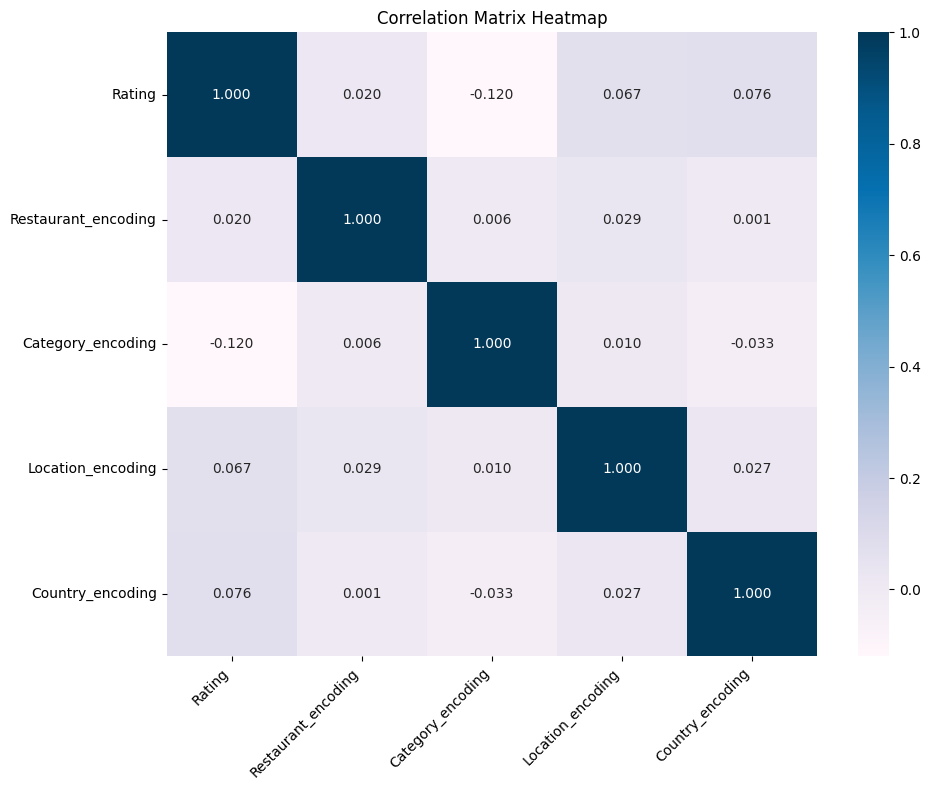

In [ ]:
# Correlation Matrix
corr_matrix = df.drop(columns=['Review_id']).corr(numeric_only=True)

# Plot the heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, fmt=".3f", cbar=True, cmap='PuBu')

# Formatting the plot
plt.xticks(rotation=45, ha='right', fontsize=10)  # Rotate labels and adjust alignment to 'right'
plt.yticks(fontsize=10)
plt.title('Correlation Matrix Heatmap')
plt.tight_layout()

# Save the plot as a PNG file
plt.savefig('heatmap.png', dpi=300)

plt.show()

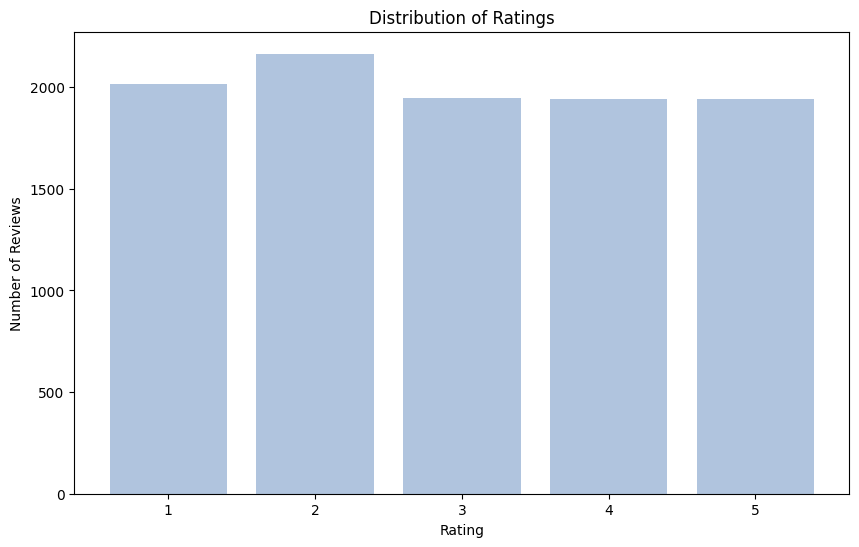

In [ ]:
#Boxplot of Ratings

plt.figure(figsize=(10, 6))
rating_distribution = df['Rating'].value_counts().sort_index()
plt.bar(rating_distribution.index, rating_distribution.values, color = 'lightsteelblue')
plt.xlabel('Rating')
plt.ylabel('Number of Reviews')
plt.title('Distribution of Ratings')
plt.xticks(rating_distribution.index)
plt.savefig('Ratings.png')

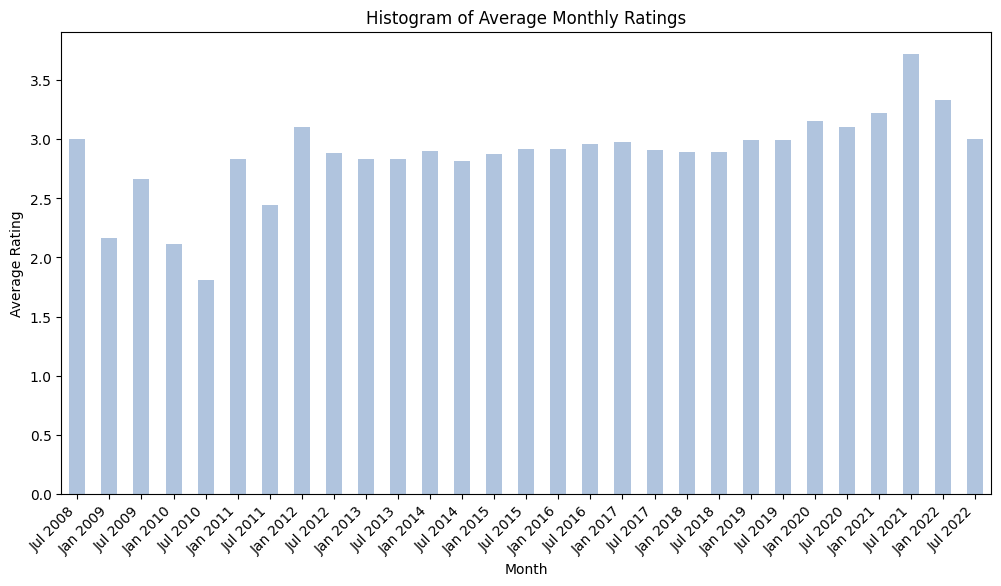

In [ ]:
#Ratings over time
fig, ax= plt.subplots(figsize=(12, 6))
monthly_ratings = df.resample('6M', on='Dates')['Rating'].mean()
monthly_ratings.plot(kind='bar', ax=ax, color = 'lightsteelblue')


# Manually set the x-axis labels
x_labels = monthly_ratings.index.strftime('%b %Y')
ax.set_xticklabels(x_labels, rotation=45, ha='right')

# Setting labels and title
ax.set_title('Histogram of Average Monthly Ratings')
ax.set_xlabel('Month')
ax.set_ylabel('Average Rating')

# Additional plot settings
plt.xticks(rotation=45)
plt.savefig('histogram.png')

Category of each restaurant and average rating

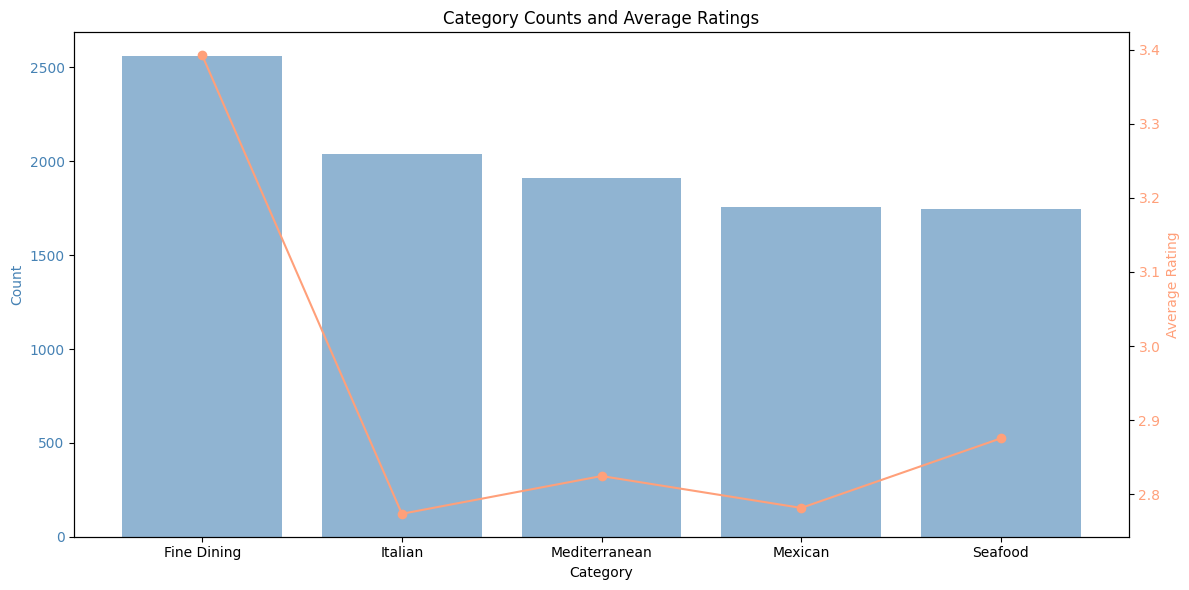

In [ ]:
# Calculate the count of each category and the average rating
category_counts = df['Category'].value_counts()
category_avg_ratings = df.groupby('Category')['Rating'].mean()

# Create a plot with two y-axes
fig, ax1 = plt.subplots(figsize=(12, 6))

# Plot the category counts
color = 'steelblue'
ax1.set_xlabel('Category')
ax1.set_ylabel('Count', color=color)
ax1.bar(category_counts.index, category_counts.values, color=color, alpha=0.6)
ax1.tick_params(axis='y', labelcolor=color)

# Create a second y-axis to plot the average ratings
ax2 = ax1.twinx()
color = 'lightsalmon'
ax2.set_ylabel('Average Rating', color=color)
ax2.plot(category_avg_ratings.index, category_avg_ratings.values, color=color, marker='o')
ax2.tick_params(axis='y', labelcolor=color)

# Set the title
plt.title('Category Counts and Average Ratings')

# Add labels and formatting
plt.xticks(rotation=45, ha='right')
fig.tight_layout()

# Display the plot
plt.savefig('category and ratings.png')
plt.show()

In [ ]:
df.to_csv('review_train_cleaned.csv')

# Task B

In [ ]:
df_train = pd.read_csv('review_train_cleaned.csv')

In [ ]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report
from sklearn.feature_extraction.text import TfidfVectorizer
import nltk
from nltk.corpus import stopwords
nltk.download('stopwords')

## Preprocessing of the text

In [ ]:
import re
from nltk.corpus import stopwords

def clean_text(text):
    # Remove non-letters
    letters_only = re.sub("[^a-zA-Z]", " ", text)

    # Convert to lower case, split into individual words
    words = letters_only.lower().split()

    # Searching a set is much faster than searching a list, so convert the stopwords to a set
    stops = set(stopwords.words('english'))

    # Remove stopwords
    meaningful_words = [w for w in words if not w in stops]

    # Join the words back into one string separated by space
    return(" ".join(meaningful_words))

# Apply the function to clean the reviews
df['clean_review'] = df['Review'].apply(clean_text)


## Create tfidf model

In [ ]:
tfidf_vectorizer = TfidfVectorizer(max_features=5000)

# Fit the model and transform the data
X = tfidf_vectorizer.fit_transform(df['clean_review']).toarray()

y = df['Rating']  # Assuming 'Rating' is the target variable

# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)


Set up Hyperparameter optimization

In [ ]:
# Initialize the RandomForestClassifier
rf = RandomForestClassifier(random_state=42)

# Create the parameter grid
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_features': ['auto', 'sqrt'],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2]
}

Configure Gridsearch


In [ ]:
# Configure GridSearchCV
grid_search = GridSearchCV(estimator=rf, param_grid=param_grid, cv=5, scoring='accuracy', verbose=1, n_jobs=-1)

# Fit GridSearchCV
grid_search.fit(X_train, y_train)



Fitting 5 folds for each of 72 candidates, totalling 360 fits


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


GridSearchCV(cv=5, estimator=RandomForestClassifier(random_state=42), n_jobs=-1,
             param_grid={'max_depth': [None, 10, 20],
                         'max_features': ['auto', 'sqrt'],
                         'min_samples_leaf': [1, 2],
                         'min_samples_split': [2, 5],
                         'n_estimators': [100, 200, 300]},
             scoring='accuracy', verbose=1)

Evaluate Hyperparameters

In [ ]:
# Best parameters found by GridSearchCV
print("Best parameters:", grid_search.best_params_)

# Prediction on the test set
predictions = grid_search.predict(X_test)

# Evaluate the model
print(classification_report(y_test, predictions))
print("Accuracy:", accuracy_score(y_test, predictions))

Best parameters: {'max_depth': None, 'max_features': 'auto', 'min_samples_leaf': 2, 'min_samples_split': 5, 'n_estimators': 200}
              precision    recall  f1-score   support

           1       0.50      0.66      0.57       109
           2       0.39      0.32      0.35       122
           3       0.36      0.27      0.31       101
           4       0.40      0.33      0.36        93
           5       0.58      0.75      0.65        95

    accuracy                           0.46       520
   macro avg       0.45      0.47      0.45       520
weighted avg       0.44      0.46      0.45       520

Accuracy: 0.46153846153846156


Use the best model

In [ ]:
# Using the best model from grid search
best_rf_model = grid_search.best_estimator_
print(best_rf_model)

RandomForestClassifier(max_features='auto', min_samples_leaf=2,
                       min_samples_split=5, n_estimators=200, random_state=42)
